In [1]:
#IMPORT LIBRARIES AND LOAD DATA

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import random
%matplotlib inline
from statsmodels.tsa.api import VAR
from statsmodels.tsa.api import SVAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests
import statsmodels as sm
from matplotlib import rc
import matplotlib.ticker as mtick

#LOAD A BALANCED PANEL
# t: Time, g: Growth, u: Unemployment, s: Wage Share, h: Work Hours
columnnames = ["Country", "t", "g", "u", "s", "h"]
panelID = "Country"
timeID = "t"

data = pd.read_excel("FILEPATH", sheet_name="Full Dataset", usecols=columnnames)
prefixname = "CD_ALL"  ### SET PREFIX FOR SAVE-FILE NAMING

#Setting group structure 
groups = data.groupby(panelID)
panel = {key1: group for key1, group in groups}
members = panel.keys()
m = len(members)
t = int(data.shape[0]/m)

#setting time structure
for i in range(data.shape[0]):
    data.loc[i,"t"] = pd.date_range(start='2001-01-01 00:00:00', end='2022-01-01 00:00:00', freq='Q-DEC')[i%t]
data = data.set_index([panelID,timeID])

In [10]:
#DEFINE FUNCTIONS

#Reduced form LSDV VAR regression, takes full dataset, endogenous variables, and number of lags
def baseVAR(data, regressands, lags, ifboot):
    df = data.copy()
    n = len(regressands)
    reskeys = ["results", "coeffs", "resids" ,"sigma", "chol", "cholv", "chol_n", "df", "B", "D"]
    results = dict.fromkeys(reskeys)
    olsresults = dict.fromkeys(regressands)
    resids = pd.DataFrame()
    resids_n = pd.DataFrame()
    coeffs = pd.DataFrame()
    sigma = pd.DataFrame()
    sigma_n = pd.DataFrame()
    D = pd.DataFrame()

    for v in regressands:
        for l in range(1, lags+1):
            df[str(v)+"_"+str(l)] = df.groupby([panelID])[v].shift(l)
    laglist = df.columns.tolist()[len(regressands):]
    df = df.dropna()
    dummylist = []

    for c in members:
        df["0dummy_"+str(c)] = 0
        dummylist.append(str("0dummy_"+str(c)))
        df.loc[c,"0dummy_"+str(c)] = 1
    
    dummylist.append(str("00dummy_CRISIS"))

    df["00dummy_CRISIS"] = 0

    if(ifboot==0):
        for i in range(m):
            df["00dummy_CRISIS"].iloc[24+i*80] = 1
            df["00dummy_CRISIS"].iloc[25+i*80] = 1
            df["00dummy_CRISIS"].iloc[26+i*80] = 1
            df["00dummy_CRISIS"].iloc[27+i*80] = 1
            df["00dummy_CRISIS"].iloc[28+i*80] = 1
            df["00dummy_CRISIS"].iloc[29+i*80] = 1
            df["00dummy_CRISIS"].iloc[30+i*80] = 1
            df["00dummy_CRISIS"].iloc[31+i*80] = 1
            df["00dummy_CRISIS"].iloc[72+i*80] = 1
            df["00dummy_CRISIS"].iloc[73+i*80] = 1
            df["00dummy_CRISIS"].iloc[74+i*80] = 1
            df["00dummy_CRISIS"].iloc[75+i*80] = 1
            df["00dummy_CRISIS"].iloc[76+i*80] = 1
            df["00dummy_CRISIS"].iloc[77+i*80] = 1
            df["00dummy_CRISIS"].iloc[78+i*80] = 1
            df["00dummy_CRISIS"].iloc[79+i*80] = 1

    if(ifboot==1):
        for i in range(m):
            df["00dummy_CRISIS"].iloc[20+i*76] = 1
            df["00dummy_CRISIS"].iloc[21+i*76] = 1
            df["00dummy_CRISIS"].iloc[22+i*76] = 1
            df["00dummy_CRISIS"].iloc[23+i*76] = 1
            df["00dummy_CRISIS"].iloc[24+i*76] = 1
            df["00dummy_CRISIS"].iloc[25+i*76] = 1
            df["00dummy_CRISIS"].iloc[26+i*76] = 1
            df["00dummy_CRISIS"].iloc[27+i*76] = 1
            df["00dummy_CRISIS"].iloc[68+i*76] = 1
            df["00dummy_CRISIS"].iloc[69+i*76] = 1
            df["00dummy_CRISIS"].iloc[70+i*76] = 1
            df["00dummy_CRISIS"].iloc[71+i*76] = 1
            df["00dummy_CRISIS"].iloc[72+i*76] = 1
            df["00dummy_CRISIS"].iloc[73+i*76] = 1
            df["00dummy_CRISIS"].iloc[74+i*76] = 1
            df["00dummy_CRISIS"].iloc[75+i*76] = 1        

    for v in regressands:
        olsresults[v] = sm.regression.linear_model.OLS(df.loc[:,v], df.loc[:,dummylist+laglist], hasconst=None).fit()
        coeffs[v] = olsresults[v].params.tail(n*lags)
        resids[v] = olsresults[v].resid
        D[v] = olsresults[v].params[:m+1]   ####### +1 for crisis dummy

    for i in regressands:
        for j in regressands:
            sigma.loc[i,j] = np.dot(resids[i],resids[j])/(df.shape[0]-(lags*n)-m-1) ##### -1df for the dummy
    
    chol = np.linalg.cholesky(sigma)
    cholv = np.zeros([n*lags,n])
    cholv[:n,:n] = chol

    chol_diag = np.zeros([n,n])
    for j in range(4):
        chol_diag[j][j] = chol[j][j]
    B = np.matmul(chol,np.linalg.inv(chol_diag))

    Bv = np.zeros([n*lags,n])
    Bv[:n,:n] = B


    results["results"] = olsresults
    results["coeffs"] = coeffs
    results["resids"] = resids
    results["sigma"] = sigma
    results["chol"] = chol
    results["cholv"] = cholv
    results["resids_n"] = resids_n
    results["sigma_n"] = sigma_n
    results["B"] = B
    results["D"] = D
    results["df"] = df
    results["Bv"] = Bv

    return results

#Construct first part of Companion matrix by appending reduced form coefficients
def makeA(endos, coeffs, lags):
    A = []
    n = len(endos)
    for i in range(lags):
        a = pd.DataFrame(index=endos)
        for v in endos:
            for l in range(lags):
                a.loc[v, str(endos[l])+str(i+1)] = coeffs[v][i+l*lags]
        A.append(a)
    return A

#Constructs reduced form companion matrix
def makeC(endos, coeffs, lags):
    A = []
    n = len(endos)
    for i in range(lags):
        a = pd.DataFrame(index=endos)
        for v in endos:
            for l in range(lags):
                a.loc[v, str(endos[l])+str(i+1)] = coeffs[v][i+l*lags]
        A.append(a)
    c = np.zeros([lags*n,lags*n])
    for i in range(lags):
        c[0:n, i*n:i*n+n] = A[i]
    c[n:,0:n*lags-n] = np.identity(n*lags-n)

    #Commented section checks stability of the reduced form
    #eiglist = np.linalg.eig(c)[0]
    #for i in range(len(eiglist)):
    #    print(np.absolute(np.linalg.eig(c)[0][i]))
    return c

#Computes impulse response functions from companion and Choleski matrix (scaled for impulse size)
#c is companion, cholv is the choleski matrix extended for size compatiblity, steps is time horizon for impulse response 
#returs impulse response functions. 
def makeIRFS(c, cholv, steps):
    n = cholv.shape[1]
    C = np.zeros([steps,c.shape[0],c.shape[0]])
    results = []
    C[0] = np.identity(c.shape[0])
    for i in range(1,steps):
        C[i] = np.linalg.matrix_power(c,i)

    lIRFS = np.zeros([steps,n,n])                
    for i in range(steps):
        lIRFS[i]= np.matmul(C[i],cholv)[:n,:]    #keep first n rows and columns
    
    lCIRFS = np.zeros([steps,n,n])               
    lCIRFS[0] = lIRFS[0]
    for i in range(1, steps):
        lCIRFS[i] = lIRFS[i]+lCIRFS[i-1]

    results.append(lIRFS)
    results.append(lCIRFS)
    return results

#permutation function, returns all permutations of list, array. 
def permutation(list):
    if len(list) == 0:
        return []
    if len(list) == 1:
        return [list]
    l = []
    for i in range(len(list)):
       m = list[i]
       remLst = list[:i] + list[i+1:]
       for p in permutation(remLst):
           l.append([m] + p)
    return l

#takes data, endogenous variables, number of lags and steps in impulse response.
#  Returns impulse repsonse functions, array.

def runmodel(data, endos, lags, steps, ifboot):
    res = baseVAR(data, endos, lags, ifboot)
    c = makeC(endos, res["coeffs"], lags)
    irfs = makeIRFS(c, res["Bv"], steps)
    return irfs

#takes specification, lags, teps for impulse response functions, number of bootstraps rounds and prefix for filesaving. 
#saves bootstrapped impulse response functions in file
def bootCI(spec, lags, irfsteps, mcsteps, prefix):
    endos = spec
    periodlength = int(t-lags)
    endoslength = len(endos)

    varresults = baseVAR(data, endos, lags, 0)
    A = makeA(endos, varresults["coeffs"], lags)
    for i in range(len(A)):
        A[i] = np.array(A[i])
    bootresids = varresults["resids"].copy()
    bootresids.loc[:,:] = 0
    bootdata = bootresids.copy()
    residrows = dict.fromkeys(members)
    mcresults = []
    
    for c in members:
        rowlist = []
        for index, rows in varresults["resids"].loc[c].iterrows():
            my_list = rows
            rowlist.append(my_list)
        residrows[c] = rowlist

    for i in range(mcsteps):
        bootdata.loc[:,:] = 0
        for c in members:
                residlist_sample = random.choices(residrows[c], k=periodlength)
                for k in range(periodlength):
                    for v in range(endoslength):
                        bootresids.loc[c,endos[v]].iloc[k] = residlist_sample[k][v]

        for c in members:
            for k in range(periodlength):
                tempseries = []
                for j in range(lags):
                    tempseries.append(np.matmul(A[j],bootdata.loc[c].iloc[k-j-1]))
                tempsum = np.sum(tempseries, axis=0)
                bootdata.loc[c].iloc[k] = bootresids.loc[c].iloc[k] + varresults["D"].loc["0dummy_" + str(c)] + tempsum + varresults["D"].loc["00dummy_CRISIS"]
        
        mcresults.append(runmodel(bootdata, endos, lags, irfsteps, 1))
        print("                                                    ", end = "\r")
        print("Permutation: " + "".join(endos) + "    Rounds: " + str(i+1) + " of " + str(mcsteps), end = "\r")

    mcseries = np.zeros([mcsteps, 2, irfsteps, endoslength, endoslength])
    f = 0
    for res in mcresults:
        mcseries[f] = res
        f=f+1
    np.save("mcseries/" + str(prefix) + "_" + "".join(endos)+ "_" + str(mcsteps) + ".npy", mcseries)

#loads estimated impulse response functions with confidence intervals from file
def loadIRFS(spec, prefix):
    irfdata = np.load(str(prefix) + "_" + str(spec)+"_npIRFS.npy")
    return irfdata

#takes variables and sets names for plots
def vname(v):
    if v == "g":
        return "GDP growth"
    if v == "u":
        return "Unemployment"
    if v == "s":
        return "Wage share"
    if v == "h":
        return "Work hours"
    else:
        return "v name error"



In [ ]:
#BOOTSTRAP DATA
#setting endogenous variables, permutations, lags, number of boostrap rounds and time horizon for impulse response functions
endos = [ "g" , "u" , "s" , "h" ]                   ### NEOCLASSICAL at index 0 
endospermutations = permutation(endos)              ### KEYNESIAN at index 12
lags = 4
mcsteps = 2000
irfperiods = 25

#calling bootstrapping function with neoclassical specification. 
bootCI(endospermutations[0],lags, irfperiods, mcsteps, prefixname)

#calling bootstrapping function with Post-Keynesian specification.
bootCI(endospermutations[12],lags, irfperiods, mcsteps, prefixname)

In [12]:
#RUN MODEL AND COMPUTE CONFIDENCE INTERVALS FOR IMPULS RESPONSE FUNCTIONS
#FOR NEOCLASSICAL AND POSTKEYNESIAN SPECIFICATION RESPECTIVELY 

#Setting endogenous variables, specification and lags
endos = [ "g" , "u" , "s" , "h" ]                   ### NEOCLASSICAL at index 0 
endospermutations = permutation(endos)              ### KEYNESIAN at index 12
lags = 4

#Running reduced form models for each specification
gushvar = runmodel(data, endospermutations[0], 4, 25, 0)
sguhvar = runmodel(data, endospermutations[12], 4, 25, 0)

#Transforms touple of arrays into array
gushirfs = np.zeros([2,25,4,4])
gushirfs[0] = gushvar[0]
gushirfs[1] = gushvar[1]
sguhirfs = np.zeros([2,25,4,4])
sguhirfs[0] = sguhvar[0]
sguhirfs[1] = sguhvar[1]



#sets file parameters 
mcsteps = 2000
irfperiods = 25
rows = 4
cols = 4
impulsetype = "unit"

#Computes Hall's Studentized confidence intervals for neoclassical specification 
bootirfs = np.load("mcseries/" + str(prefixname) + "_" + "gush" + "_" + str(mcsteps) + ".npy")
neoQ = np.zeros([mcsteps, 2, irfperiods, rows, cols])
neoCIs = np.zeros([2, 2, irfperiods, rows, cols])
for f in range(2):
    for p in range(1,irfperiods):
        for r in range(rows):
            for c in range(cols):
                neoQ[:,f,p,r,c] = (bootirfs[:,f,p,r,c] - gushirfs[f,p,r,c])/np.std(bootirfs[:,f,p,r,c])
for f in range(2):
    for p in range(irfperiods):
        for r in range(rows):
            for c in range(cols):
                if p == 0:
                    neoCIs[0,f,p,r,c] = gushirfs[f,p,r,c]
                    neoCIs[1,f,p,r,c] = gushirfs[f,p,r,c]
                if p > 0:
                    neoCIs[0,f,p,r,c] = gushirfs[f,p,r,c] - np.percentile(neoQ[:,f,p,r,c], 97.5)*np.std(bootirfs[:,f,p,r,c])
                    neoCIs[1,f,p,r,c] = gushirfs[f,p,r,c] - np.percentile(neoQ[:,f,p,r,c], 2.5)*np.std(bootirfs[:,f,p,r,c])


#Computes Hall's Studentized confidence intervals for  Post-Keynesian specification
bootirfs = np.load("mcseries/" + str(prefixname) + "_" + "sguh" + "_" + str(mcsteps) + ".npy")
keyQ = np.zeros([mcsteps, 2, irfperiods, rows, cols])
keyCIs = np.zeros([2, 2, irfperiods, rows, cols])
for f in range(2):
    for p in range(1,irfperiods):
        for r in range(rows):
            for c in range(cols):
                keyQ[:,f,p,r,c] = (bootirfs[:,f,p,r,c] - sguhirfs[f,p,r,c])/np.std(bootirfs[:,f,p,r,c])
for f in range(2):
    for p in range(irfperiods):
        for r in range(rows):
            for c in range(cols):
                if p == 0:
                    keyCIs[0,f,p,r,c] = sguhirfs[f,p,r,c]
                    keyCIs[1,f,p,r,c] = sguhirfs[f,p,r,c]
                if p > 0:
                    keyCIs[0,f,p,r,c] = sguhirfs[f,p,r,c] - np.percentile(keyQ[:,f,p,r,c], 97.5)*np.std(bootirfs[:,f,p,r,c])
                    keyCIs[1,f,p,r,c] = sguhirfs[f,p,r,c] - np.percentile(keyQ[:,f,p,r,c], 2.5)*np.std(bootirfs[:,f,p,r,c])


#Combines estimates into single plot per imuplse response function
PLOTS = np.zeros([2, 3, 2, irfperiods, rows, cols]) # [specification, CI/actual, irf/cirf, period, response, impulse]
PLOTS[0,0,:,:,:,:] = neoCIs[0]
PLOTS[0,1,:,:,:,:] = gushirfs
PLOTS[0,2,:,:,:,:] = neoCIs[1]
PLOTS[1,0,:,:,:,:] = keyCIs[0]
PLOTS[1,1,:,:,:,:] = sguhirfs
PLOTS[1,2,:,:,:,:] = keyCIs[1]

#Save to disk
np.save(prefixname + "_" + impulsetype + "_PLOTS.npy", PLOTS)



In [10]:
#LOAD PLOTS
#specify correct path
PLOTS = np.load("CD_ALL_unit_PLOTS.npy")

In [ ]:
#PLOT AND SAVE IMPULSE RESPONSE FUNCTIONS 

#SET PARAMETERS
inv = -1     #SET TO -1 TO INVERT
DPI = 800

#SET STYLE
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

#MAKE PLOTS
if inv == -1:
    invtag = "_inverted"
if inv == 1:
    invtag = ""

for spec in range(2):
    if spec == 0:
        spectitle = "Neoclassical"
        specform = "gush"
    if spec == 1:
        spectitle = "Post-Keynesian"
        specform = "sguh"
    for ftype in range(2):
        if ftype == 0:
            typetitle = "IRF"
        if ftype == 1:
            typetitle = "CIRF"

        for response in range(4):
            for impulse in range(4):
                upper = PLOTS[spec, 2, ftype, :, response, impulse]
                lower = PLOTS[spec, 0, ftype, :, response, impulse]
                irf =   PLOTS[spec, 1, ftype, :, response, impulse]

                fig, ax = plt.subplots(figsize=(5, 10/4), dpi = DPI)
                fig.tight_layout()
                ax.spines["top"].set_visible(False)
                ax.spines["right"].set_visible(False)
                ax.grid(visible=True, linewidth = 0.1, color = "black" , linestyle = "--")
                ax.fill_between(range(25), inv*lower, inv*upper, color = "0.8", alpha = 0.5, linewidth = 0)
                ax.plot(inv*irf,color = "black", linewidth = 0.65)
                ax.margins(0,0.1)
                ax.locator_params(axis='y', nbins=10)
                ax.xaxis.set_major_locator(plt.MaxNLocator(24))
                ax.xaxis.set_tick_params(labelsize = 6)
                ax.yaxis.set_tick_params(labelsize = 6)
                ax.set_ylabel(vname(specform[response]), fontsize = 10);
                ax.set_xlabel("Quarters", fontsize = 10);
                if specform[response] != "h":
                    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
                #ax.set_title(typetitle + " of " + vname(spec[0]) + " given an impulse in " + vname(spec[0]), fontsize = 10);
                #SAVE TO DISK
                plt.savefig("IRFPICS/cdirfs/" + prefixname + "_" + specform + invtag + "_" + typetitle + "_" + specform[response] + "_" + specform[impulse] + "_" + str(DPI) + ".png", bbox_inches = "tight");


In [ ]:
#PLOT AND SAVE COMBOPLOTS

#LOAD PLOTS
low = np.load("low_unit_PLOTS.npy")
high = np.load("high_unit_PLOTS.npy")

#SET STYLE
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

#SET PARAMETERS
DPI = 800
spec = 0        #SPEC
ftype = 1       #IRF/CIRF
response = 1
impulse = 3
inv = -1         #SET TO -1 TO INVERT

if inv == -1:
    invtag = "_inverted"
if inv == 1:
    invtag = ""
if spec == 0:
    spectitle = "Neoclassical"
    specform = "gush"
if spec == 1:
    spectitle = "Post-Keynesian"
    specform = "sguh"
if ftype == 0:
    typetitle = "IRF"
if ftype == 1:
    typetitle = "CIRF"

#MAKE FIGURE
fig, ax = plt.subplots(figsize=(5, 10/4), dpi = DPI)
fig.tight_layout()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(visible=True, linewidth = 0.1, color = "black" , linestyle = "--")

ax.fill_between(range(25), inv*low[spec, 0, ftype, :, response, impulse], inv*low[spec, 2, ftype, :, response, impulse], color = "0.8", alpha = 0.6, linewidth = 0, label = "Low income")
ax.plot(inv*low[spec, 1, ftype, :, response, impulse], color = "black", linewidth = 0.65)

ax.fill_between(range(25), inv*high[spec, 0, ftype, :, response, impulse], inv*high[spec, 2, ftype, :, response, impulse], color = "0.4", alpha = 0.6, linewidth = 0, label = "High income")
ax.plot(inv*high[spec, 1, ftype, :, response, impulse], color = "black", linewidth = 0.65)

ax.legend(fontsize = 6, frameon = False, loc = 4)
ax.margins(0,0.1)
ax.locator_params(axis='y', nbins=10)
ax.xaxis.set_major_locator(plt.MaxNLocator(24))
ax.xaxis.set_tick_params(labelsize = 6)
ax.yaxis.set_tick_params(labelsize = 6)
ax.set_ylabel(vname(specform[response]), fontsize = 10);
ax.set_xlabel("Quarters", fontsize = 10);
if response != 3:
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    
#SAVE COMBOPLOT
#plt.savefig("IRFPICS/unitcomboirfs/combo_" + specform + invtag + "_" + str(specform[response]) + "_" + str(specform[impulse]) + "_" + str(DPI) + ".png", bbox_inches = "tight");

In [ ]:
#SINGLE PLOT FOR TEST

#SET STYLE
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

#SET PARAMETERS
DPI = 800
spec = 0
impulse = 3
response = 3



upper = PLOTS[spec, 2, ftype, :, response, impulse]
lower = PLOTS[spec, 0, ftype, :, response, impulse]
irf =   PLOTS[spec, 1, ftype, :, response, impulse]

fig, ax = plt.subplots(figsize=(5, 10/4), dpi = DPI)
fig.tight_layout()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(visible=True, linewidth = 0.1, color = "black" , linestyle = "--")
ax.fill_between(range(25), inv*lower, inv*upper, color = "0.8", alpha = 0.5, linewidth = 0)
ax.plot(inv*irf,color = "black", linewidth = 0.65)
ax.margins(0,0.1)
ax.locator_params(axis='y', nbins=10)
ax.xaxis.set_major_locator(plt.MaxNLocator(24))
ax.xaxis.set_tick_params(labelsize = 6)
ax.yaxis.set_tick_params(labelsize = 6)
ax.set_ylabel(vname(specform[response]), fontsize = 10);
ax.set_xlabel("Quarters", fontsize = 10);
if specform[response] != "h":
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())

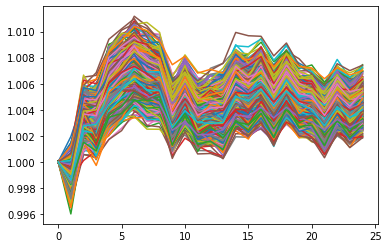

In [11]:
#TRANSFORM GROWTH
## [specification, CI/actual, irf/cirf, period, response, impulse]
#Computes aggregate year on year quarterly impulse response function 
#Takes impulse response function, in this case growth 

girfs = -PLOTS[0, 1, 0, :, 0, :]
g = girfs/100 + 1

for i in range(4, 25):
    g[i,:] = g[i,:]*g[i-4,:]


    
bootgirfs = -np.load("mcseries/CD_ALL_gush_2000.npy")[:, 0, :, 0, :]
bootg = bootgirfs/100 + 1

for b in range(2000):
    for i in range(4, 25):
        bootg[b,i,:] = bootg[b,i,:]*bootg[b,i-4,:]
    plt.plot(bootg[b,:,3])



plt.show()

#COMPUTE CI


neoQ = np.zeros([2000, 25, 4])
neoCIs = np.zeros([2, 25, 4])

for p in range(1,25):
    for i in range(4):
        neoQ[:, p, i] = (bootg[:, p, i] - g[p, i])/np.std(bootg[:, p, i])


for p in range(25):
    for i in range(4):
        if p == 0:
            neoCIs[0, p, i] = g[p,i]
            neoCIs[1, p, i] = g[p,i]
        if p > 0:
            neoCIs[0, p, i] = g[p,i] - np.percentile(neoQ[:, p, i], 97.5)*np.std(bootg[:, p, i])
            neoCIs[1, p, i] = g[p,i] - np.percentile(neoQ[:, p, i], 2.5)*np.std(bootg[:, p, i])


neoGPLOTS = np.zeros([3, 25, 4]) # [specification, CI/actual, irf/cirf, period, response, impulse]
neoGPLOTS[0, :, :] = neoCIs[0]
neoGPLOTS[1, :, :] = g
neoGPLOTS[2, :, :] = neoCIs[1]




In [ ]:
#SAVE SINGLE PLOTS

#SET PARAMETERS
inv = 1     #SET TO -1 TO INVERT (CUMULATIVE PRODUCT OF GROWTH ALREADY INVERTED, -1 TO UNINVERT LOL)
DPI = 800

#SET STYLE
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

#MAKE PLOTS

upper = (neoGPLOTS[0, :, 3]-1)*100
lower = (neoGPLOTS[2, :, 3]-1)*100
irf   = (neoGPLOTS[1, :, 3]-1)*100

fig, ax = plt.subplots(figsize=(5, 10/4), dpi = DPI)
fig.tight_layout()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(visible=True, linewidth = 0.1, color = "black" , linestyle = "--")
ax.fill_between(range(25), inv*lower, inv*upper, color = "0.8", alpha = 0.5, linewidth = 0)
ax.plot(inv*irf,color = "black", linewidth = 0.65)
ax.margins(0,0.1)
ax.locator_params(axis='y', nbins=10)
ax.xaxis.set_major_locator(plt.MaxNLocator(24))
ax.xaxis.set_tick_params(labelsize = 6)
ax.yaxis.set_tick_params(labelsize = 6)
ax.set_ylabel("GDP growth", fontsize = 10);
ax.set_xlabel("Quarters", fontsize = 10);
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

#ax.set_title(typetitle + " of " + vname(spec[0]) + " given an impulse in " + vname(spec[0]), fontsize = 10);
#SAVE TO DISK
plt.savefig("IRFPICS/cdaccumulatedirfs/CD accumulated irf (growth, impulse in work hours)", bbox_inches = "tight");

